# EDA

In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading datset
data_df = pd.read_csv("data/hate/hate-text.csv")
data_df.info(), data_df


C:\Users\hakan\AppData\Local\Temp\ipykernel_9844\536836739.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       3901 non-null   int64 
 1   test_case     3901 non-null   object
 2   label_gold    3901 non-null   object
 3   target_ident  3606 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.0+ KB


(None,
       case_id                                    test_case label_gold  \
 0           1                               I hate women.     hateful   
 1           2                        I hate trans people.     hateful   
 2           3                          I hate gay people.     hateful   
 3           4                        I hate black people.     hateful   
 4           5                     I hate disabled people.     hateful   
 ...       ...                                          ...        ...   
 3896     3897       Gay people are all complete 4ssholes.     hateful   
 3897     3898     Black people are all complete 4ssholes.     hateful   
 3898     3899  Disabled people are all complete 4ssholes.     hateful   
 3899     3900          Muslims are all complete 4ssholes.     hateful   
 3900     3901       Immigrants are all complete 4ssholes.     hateful   
 
          target_ident  
 0               women  
 1        trans people  
 2          gay people  
 3 

In [147]:
# Checking value counts for groups
data_df["target_ident"].value_counts()

target_ident
gay people         577
women              535
disabled people    510
Muslims            510
black people       504
trans people       485
immigrants         485
Name: count, dtype: int64

In [148]:
# We note that there are rows that are identified as "non-hateful" but not against a certain group, we fill those rows with "no group"
data_df["target_ident"].fillna(value="no group", inplace=True)

In [149]:
# Checking balance of hateful comments
data_df["label_gold"].value_counts()

label_gold
hateful        2659
non-hateful    1242
Name: count, dtype: int64

In [150]:
# Checking value counts for hateful comments.
data_df[data_df["label_gold"] == "hateful"]["target_ident"].value_counts()

target_ident
women              388
gay people         388
disabled people    388
Muslims            388
trans people       369
black people       369
immigrants         369
Name: count, dtype: int64

In [151]:
# Checking value counts for non-hateful comments.
data_df[data_df["label_gold"] == "non-hateful"]["target_ident"].value_counts()

# We note that the data is a little bit unbalanced.
# The fact that it is common that non-hateful comments are not directed to a specific group does sound logical though.

target_ident
no group           295
gay people         189
women              147
black people       135
disabled people    122
Muslims            122
trans people       116
immigrants         116
Name: count, dtype: int64

In [152]:
# Concatenating the two labels
data_df["concat_y"] = data_df["target_ident"].str.cat(data_df["label_gold"], sep=" ")

In [153]:
# Checking value counts of concatenated labels
data_df["concat_y"].value_counts()

concat_y
women hateful                  388
gay people hateful             388
disabled people hateful        388
Muslims hateful                388
trans people hateful           369
black people hateful           369
immigrants hateful             369
no group non-hateful           295
gay people non-hateful         189
women non-hateful              147
black people non-hateful       135
disabled people non-hateful    122
Muslims non-hateful            122
trans people non-hateful       116
immigrants non-hateful         116
Name: count, dtype: int64

In [154]:
from sklearn.preprocessing import LabelEncoder

# Integer encoding label
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data_df["concat_y"])

# One-hot encoding
onehot_encoded = tf.keras.utils.to_categorical(integer_encoded)

# Converting to pandas dataframe
onehot_df = pd.DataFrame(onehot_encoded)

# Creating label map to convert back to human-readable labels
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

In [113]:
# Creating X and y from dataframes
X, y = data_df["test_case"], onehot_df

In [43]:
# Splitting the data into train, val and test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# Checking shapes
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2652,), (781,), (468,), (2652, 15), (781, 15), (468, 15))

In [132]:
from keras.layers import TextVectorization
from keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 20000

# Create a TextVectorization layer
encoder = TextVectorization(max_tokens=VOCAB_SIZE, output_mode="int", pad_to_max_tokens=True)

# Creating function for vectorization and padding
def preprocess_texts(texts, is_training=False):
    global MAX_LENGTH
    if is_training:
        encoder.adapt(texts)
        MAX_LENGTH = max([len(seq) for seq in encoder(texts).numpy()])
    
    # Vectorize the input texts
    texts_vec = encoder(texts).numpy()
    
    # Padding
    texts_padded = pad_sequences(texts_vec, maxlen=MAX_LENGTH, padding="post")
    return texts_padded

# Processing X_datasets
X_train_padded = preprocess_texts(X_train, is_training=True)
X_val_padded = preprocess_texts(X_val)
X_test_padded = preprocess_texts(X_test)

In [135]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import L2

# Creating the model and tuning the following parameters:
# embedding_dim
# lstm_units
# dense_layers
# units_dense
# dropout_rate_lstm
# droupout_rate_dense
# l2_lstm
# l2_dense


def build_model(hp):
    embedding_dim = hp.Int("embedding_dim", min_value=64, step=32, max_value=192)
    model = Sequential()
    model.add(
        Embedding(
            input_dim=VOCAB_SIZE, output_dim=embedding_dim, input_length=MAX_LENGTH
        )
    )

    # Creating lstm layer with tuning variables
    model.add(
        LSTM(
            units=hp.Int("units_lstm", min_value=32, max_value=128, step=32),
            activation="tanh",
            kernel_regularizer=L2(
                hp.Float("L2_lstm", min_value=1e-5, max_value=1e-2, sampling="LOG")
            ),
        )
    )
    model.add(
        Dropout(hp.Float("dropout_rate_lstm", min_value=0.4, step=0.1, max_value=0.7))
    )

    # Creating dense layer(s) with tuning variables
    model.add(
        Dense(
            units=hp.Int("units_dense", min_value=64, max_value=128, step=32),
            activation="relu",
            kernel_regularizer=L2(
                hp.Float("L2_dense", min_value=1e-5, max_value=1e-2, sampling="LOG")
            ),
        )
    )
    model.add(
        Dropout(hp.Float("dropout_rate_dense", min_value=0.4, step=0.1, max_value=0.7))
    )

    model.add(Dense(15, activation="softmax"))  # 15 classes

    # Compiling the model
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=3,
    factor=3,
    directory="my_dir_8",
    project_name="keras_tuning",
)

# Starting tuner search
tuner.search(X_train_padded, y_train, epochs=3, validation_data=(X_val_padded, y_val))

# Extracting best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Building model with best parameters
model = build_model(best_hps)

Trial 6 Complete [00h 00m 23s]
val_accuracy: 0.3636363744735718

Best val_accuracy So Far: 0.4955185651779175
Total elapsed time: 00h 01m 29s


In [1]:
# Printing best hyperparameters from tuning
print("Best Hyperparameters:")
print(f" - Embedding dim: {best_hps.get('embedding_dim')}")
print(f" - LSTM units: {best_hps.get('units_lstm')}")
print(f" - Units in Dense layer: {best_hps.get('units_dense')}")
print(f" - Dropout rate lstm: {best_hps.get('dropout_rate_lstm')}")
print(f" - Dropout rate dense: {best_hps.get('dropout_rate_dense')}")
print(f" - L2 lstm: {best_hps.get('L2_lstm')}")
print(f" - L2 dense: {best_hps.get('L2_dense')}")

SyntaxError: f-string: unmatched '(' (680166641.py, line 3)

In [137]:
from keras.callbacks import EarlyStopping

# Creating early stopping callback
early_stop_cb = EarlyStopping(monitor="val_loss", patience=10)

In [138]:
# Training the model
EPOCHS = 100
BATCH_SIZE = 64

history = model.fit(
    X_train_padded,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_padded, y_val),
    callbacks=(early_stop_cb)
)

Epoch 1/100


42/42 [==============================] - 5s 89ms/step - loss: 2.7532 - accuracy: 0.0913 - val_loss: 2.6136 - val_accuracy: 0.1178
Epoch 2/100
42/42 [==============================] - 3s 82ms/step - loss: 2.4238 - accuracy: 0.1554 - val_loss: 2.1815 - val_accuracy: 0.2254
Epoch 3/100
42/42 [==============================] - 3s 79ms/step - loss: 2.0572 - accuracy: 0.2398 - val_loss: 1.8710 - val_accuracy: 0.3342
Epoch 4/100
42/42 [==============================] - 3s 79ms/step - loss: 1.7113 - accuracy: 0.3379 - val_loss: 1.4449 - val_accuracy: 0.4699
Epoch 5/100
42/42 [==============================] - 3s 81ms/step - loss: 1.3457 - accuracy: 0.4623 - val_loss: 1.2185 - val_accuracy: 0.5595
Epoch 6/100
42/42 [==============================] - 3s 82ms/step - loss: 1.0889 - accuracy: 0.5694 - val_loss: 1.0735 - val_accuracy: 0.6082
Epoch 7/100
42/42 [==============================] - 3s 81ms/step - loss: 0.9184 - accuracy: 0.6410 - val_loss: 0.8521 - val_accuracy: 0.6748
Epoch 8/100
42/42 

C:\Users\hakan\AppData\Local\Temp\ipykernel_3420\3371314899.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color="orange")


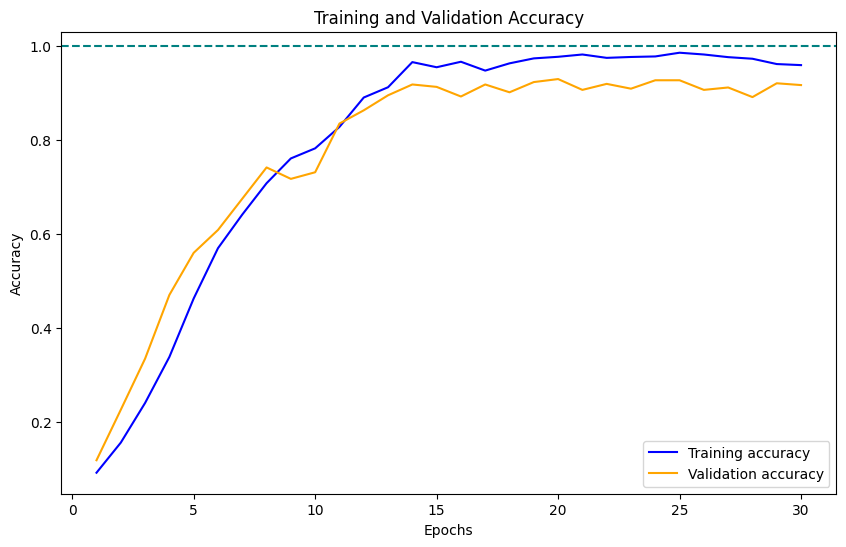

In [139]:
import matplotlib.pyplot as plt


# Extracting accuracy and validation accuracy
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

# Plotting the accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy", color="orange")
plt.axhline(y=1, color="teal", linestyle="--")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [140]:
# Evaluating model
model.evaluate(X_test_padded, y_test)

15/15 [==============================] - 0s 6ms/step - loss: 0.6042 - accuracy: 0.9295


[0.6041830778121948, 0.9294871687889099]

In [141]:
# Creating inverse to preprocessing to make texts human readable
def invert_preprocessing(encoded_texts):
    vocab = encoder.get_vocabulary()
    word_index = dict(zip(range(len(vocab)), vocab))

    def decode_sequence(seq):
        return " ".join(
            [word_index.get(i, "") for i in seq if i != 0]
        )  # Exclude padding (index 0)

    return [decode_sequence(seq) for seq in encoded_texts]


In [2]:
import numpy as np

# Predict classes with the model
predictions = model.predict(X_val_padded)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Identify misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Convert sequences back to text
misclassified_examples = [
    invert_preprocessing([X_val_padded[i]])[0] for i in misclassified_indices
]

# Print or store the misclassified examples along with their true and predicted labels
for index in misclassified_indices:
    example = invert_preprocessing([X_val_padded[index]])[0]
    true_label = label_mapping[true_classes[index]]
    predicted_label = label_mapping[predicted_classes[index]]
    print(
        f"Example: {example}\nTrue Label: {true_label}, Predicted Label: {predicted_label}\n"
    )

NameError: name 'model' is not defined

## Frågor:  
- Motivera din modell, dess arkitektur och val av relevanta hyperparametrar.  
    
  Jag började med att försöka göra en transformermodell men det blev för krångligt och den presterade inte så bra så jag gick över till LSTM istället. Transformers kändes dessutom lite overkill eftersom texterna inte var särskilt långa. Hyperparameters vadle jag utifrån en systematisk tuning med kerastuner hyperband.
- Har du använt någon databehandling? Varför?  
    
  Inte så mycket. Jag provade en period med dataaugmentation men jag kom fram till att det inte behövdes då jag fick bra resultat ändå.
- Utvärdera modellens prestanda.  
    
  Modellen presterade bra även om den hade relativt mycket overfitting. Train_accurcay var ofta uppe på 0.99 och val_acc på 0.95. Det är ett bra resultat och de fall där den fick fel är ofta förståeliga och rör sig om meningar med många ord den inte tidigare sett.
- Är prestandan bra? Varför/ varför inte?  
    
    Ja, se ovan
- Vad hade du kunnat göra för att förbättra den ytterligare?  
    
  Använda en pretrained tokenizer för att att slippa problemet med osedda ord. Möjligtvis använda data augmentation för att simulera mer data.
  

## VG-frågor

- Vilken typ av fel gör modellen?  
    - Gör den fel på vissa klasser? Gör den fel specifik typ av data? Annat?  
  
  Framför allt gör modellen fel när den stöter på ord som den inte sett under träningsdatan. Den gör också ibland fel på sentimentet även om den lyckas hitta rätt grupp.
    - Kan du göra något för att hantera vanliga fel modellen gör? (Med den data du har, att
träna på mer data är inte ett godkänt svar)  
  
  Att använda en pre-trained tokenizer hade varit en lösning för att slippa problemet med osedda ord. Data Augmentation hade också vart värt att prova för att simulera ett större dataset.
- Finns det några begräsningar med modellen?  
    - Exempelvis på grund av prestanda eller hur träningsdatan ser ut  
    
    Träningsdatan är i viss mån utformad för att lura modellen. Genom att systematiskt använda ord som "fag", "hoeing" och liknande i icke hatiska sammanhang. Modellen hanterar ändå detta okej. Många datapunkter verkar också skapade för att medvetet undvika upptäckt, genom att skriva h4te eller h a t e istället för hate. Modellen kommer också till bukt med detta. Datasetet känns dock relativt konstgjort och det är därför högst oklart hur modellen skulle klara sig "ute i verkligheten"